In [ ]:
import av
import numpy as np
from PIL import Image
import os
import time

class VideoEncoder:
    def __init__(self, block_size=16, search_radius=8):
        self.block_size = block_size
        self.search_radius = search_radius
    
    def extract_frames(self, video_path, output_dir):
        """Извлекает кадры из видео и сохраняет их как JPEG."""
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        container = av.open(video_path)
        stream = container.streams.video[0]
        
        frames = []
        for frame in container.decode(stream):
            # Преобразование в массив numpy в формате grayscale
            img_array = frame.to_ndarray(format='gray')
            frames.append(img_array)
            
        return frames
    
    def sat_metric(self, block1, block2):
        """Вычисляет метрику SAT между двумя блоками."""
        return np.sum(np.abs(block1 - block2))
    
    def logarithmic_search(self, curr_block, ref_frame, x, y):
        """Реализует логарифмический поиск для оценки движения."""
        step_size = self.search_radius
        min_x, min_y = x, y
        min_cost = float('inf')
        
        while step_size >= 1:
            for dx in [-step_size, 0, step_size]:
                for dy in [-step_size, 0, step_size]:
                    new_x = min_x + dx
                    new_y = min_y + dy
                    
                    # Проверка границ
                    if (new_x < 0 or new_x + self.block_size > ref_frame.shape[1] or
                        new_y < 0 or new_y + self.block_size > ref_frame.shape[0]):
                        continue
                    
                    ref_block = ref_frame[new_y:new_y+self.block_size, 
                                        new_x:new_x+self.block_size]
                    cost = self.sat_metric(curr_block, ref_block)
                    
                    if cost < min_cost:
                        min_cost = cost
                        min_x, min_y = new_x, new_y
            
            step_size //= 2
            
        return min_x - x, min_y - y
    
    def motion_estimation(self, current_frame, reference_frame):
        """Оценка движения для всего кадра."""
        height, width = current_frame.shape
        motion_vectors = np.zeros((height // self.block_size, 
                                 width // self.block_size, 2))
        
        for i in range(0, height - self.block_size + 1, self.block_size):
            for j in range(0, width - self.block_size + 1, self.block_size):
                curr_block = current_frame[i:i+self.block_size, 
                                        j:j+self.block_size]
                
                dx, dy = self.logarithmic_search(curr_block, reference_frame, j, i)
                
                motion_vectors[i//self.block_size, 
                            j//self.block_size] = [dx, dy]
                
        return motion_vectors
    
    def motion_compensation(self, reference_frame, motion_vectors):
        """Компенсация движения для восстановления кадра."""
        height, width = reference_frame.shape
        compensated = np.zeros_like(reference_frame)
        
        for i in range(motion_vectors.shape[0]):
            for j in range(motion_vectors.shape[1]):
                dx, dy = motion_vectors[i, j]
                
                ref_y = i * self.block_size
                ref_x = j * self.block_size
                
                src_y = int(ref_y + dy)
                src_x = int(ref_x + dx)
                
                # Проверка границ
                if (src_x >= 0 and src_x + self.block_size <= width and
                    src_y >= 0 and src_y + self.block_size <= height):
                    compensated[ref_y:ref_y+self.block_size, 
                              ref_x:ref_x+self.block_size] = \
                        reference_frame[src_y:src_y+self.block_size, 
                                     src_x:src_x+self.block_size]
                
        return compensated
    
    def encode_video(self, input_path, output_dir):
        """Основной метод кодирования видео."""
        frames = self.extract_frames(input_path, output_dir)
        
        for i in range(1, len(frames)):
            # Оценка движения
            motion_vectors = self.motion_estimation(frames[i], frames[i-1])
            
            # Компенсация движения
            compensated_frame = self.motion_compensation(frames[i-1], motion_vectors)
            
            # Разница между текущим и компенсированным кадром
            residual = frames[i] - compensated_frame
            
            # Сохранение кадра
            self.save_frame(frames[i], os.path.join(output_dir, f'frame_{i}.jpg'))
            
            # Вывод прогресса
            print(f"Обработан кадр {i} из {len(frames)-1}")
            
        return True
    
    def save_frame(self, frame, filepath):
        """Сохраняет кадр как JPEG файл."""
        # Нормализация значений для сохранения в формате JPEG
        normalized = np.clip(frame, 0, 255).astype(np.uint8)
        image = Image.fromarray(normalized)
        image.save(filepath)

def main():
    # Пути к файлам
    input_video = "lr1_1.avi"
    output_dir = "encoded_frames"
    
    # Создание выходной директории, если её нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Инициализация кодера с параметрами из задания
    encoder = VideoEncoder(block_size=16, search_radius=8)
    
    print("Начало кодирования видео...")
    start_time = time.time()
    
    try:
        # Запуск процесса кодирования
        encoder.encode_video(input_video, output_dir)
        
        # Вывод статистики
        end_time = time.time()
        processing_time = end_time - start_time
        
        print(f"Кодирование завершено успешно!")
        print(f"Время обработки: {processing_time:.2f} секунд")
        print(f"Закодированные кадры сохранены в директории: {output_dir}")
        
    except Exception as e:
        print(f"Ошибка при кодировании: {str(e)}")

if __name__ == "__main__":
    main()

Начало кодирования видео...
Обработан кадр 1 из 67
Обработан кадр 2 из 67
Обработан кадр 3 из 67
Обработан кадр 4 из 67
Обработан кадр 5 из 67
Обработан кадр 6 из 67
Обработан кадр 7 из 67
Обработан кадр 8 из 67
Обработан кадр 9 из 67
Обработан кадр 10 из 67
Обработан кадр 11 из 67
Обработан кадр 12 из 67
Обработан кадр 13 из 67
Обработан кадр 14 из 67
Обработан кадр 15 из 67
Обработан кадр 16 из 67
Обработан кадр 17 из 67
Обработан кадр 18 из 67
Обработан кадр 19 из 67
Обработан кадр 20 из 67
Обработан кадр 21 из 67
Обработан кадр 22 из 67
Обработан кадр 23 из 67
Обработан кадр 24 из 67
Обработан кадр 25 из 67
Обработан кадр 26 из 67
Обработан кадр 27 из 67
Обработан кадр 28 из 67
Обработан кадр 29 из 67
Обработан кадр 30 из 67
Обработан кадр 31 из 67
Обработан кадр 32 из 67
Обработан кадр 33 из 67
Обработан кадр 34 из 67
Обработан кадр 35 из 67
Обработан кадр 36 из 67
Обработан кадр 37 из 67
Обработан кадр 38 из 67
Обработан кадр 39 из 67
Обработан кадр 40 из 67
Обработан кадр 41 из 

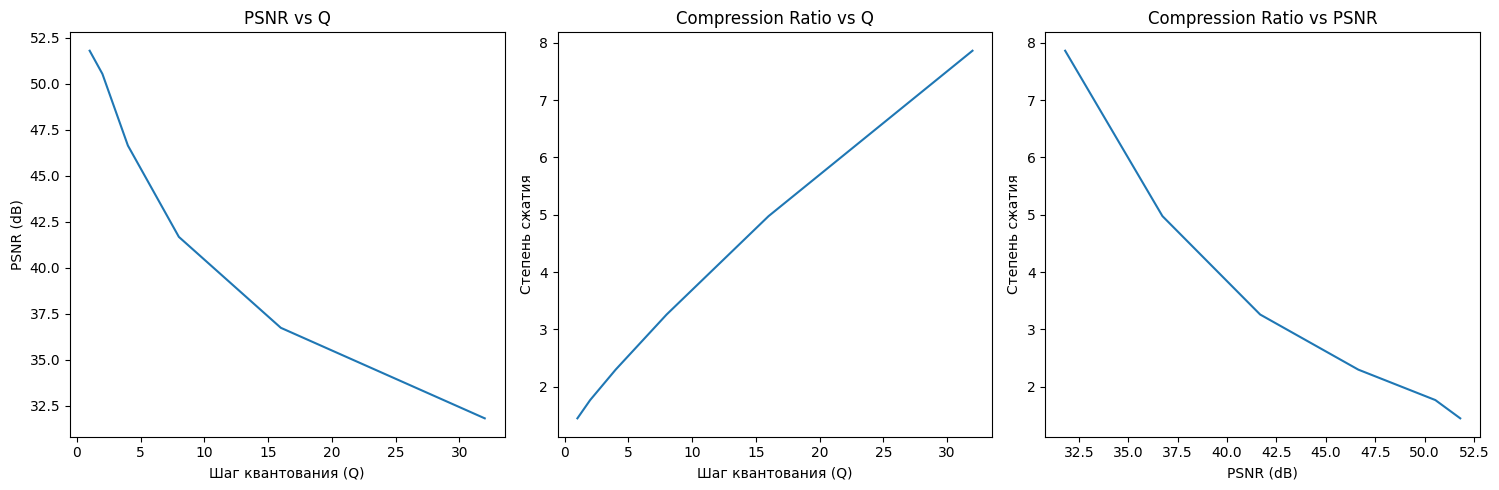

In [11]:
import av
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from scipy.fftpack import dct, idct
from collections import Counter
import math

def three_step_search(curr_block: np.ndarray,
                    reference_frame: np.ndarray,
                    x: int,
                    y: int,
                    search_radius: int = 8) -> Tuple[int, int]:
    """
    Реализация алгоритма трехшагового поиска для оценки движения
    """
    block_size = curr_block.shape[0]
    best_x, best_y = x, y
    best_sad = float('inf')
    step = search_radius

    while step >= 1:
        for dx in [-step, 0, step]:
            for dy in [-step, 0, step]:
                new_x = best_x + dx
                new_y = best_y + dy

                if (new_x < 0 or new_x + block_size > reference_frame.shape[0] or
                    new_y < 0 or new_y + block_size > reference_frame.shape[1]):
                    continue

                reference_block = reference_frame[new_x:new_x + block_size,
                                                new_y:new_y + block_size]

                sad = np.sum(np.abs(curr_block - reference_block))

                if sad < best_sad:
                    best_sad = sad
                    best_x = new_x
                    best_y = new_y
        step //= 2

    return best_x - x, best_y - y

def entropy(data: np.ndarray) -> float:
    """
    Calculate Shannon entropy of the data
    """
    counter = Counter(data.flatten())
    probabilities = [count/len(data.flatten()) for count in counter.values()]
    return -sum(p * math.log2(p) for p in probabilities)

def calculate_dct_bits(quantized_dct: np.ndarray) -> Tuple[int, int, int, int]:
    """
    Calculate bits needed for DCT coefficients encoding
    Returns: N(DC), sum(BC(dDC)), N({Run, Level}), sum(BC(Level))
    """
    blocks = quantized_dct.reshape(-1, 8, 8)
    n_blocks = len(blocks)
    
    # DC coefficients
    dc_coeffs = blocks[:, 0, 0]
    dc_diffs = np.diff(dc_coeffs)  # DPCM for DC
    dc_category = np.ceil(np.log2(np.abs(dc_diffs) + 1)).astype(int)
    dc_magnitude_bits = np.sum(dc_category)  # sum(BC(dDC))
    
    # AC coefficients
    ac_coeffs = blocks[:, :, :].reshape(-1, 64)[:, 1:]  # exclude DC
    nonzero_mask = ac_coeffs != 0
    n_nonzero = np.sum(nonzero_mask)  # N({Run, Level})
    
    # Calculate bits for AC magnitudes
    ac_category = np.ceil(np.log2(np.abs(ac_coeffs[nonzero_mask]) + 1)).astype(int)
    ac_magnitude_bits = np.sum(ac_category)  # sum(BC(Level))
    
    return n_blocks, dc_magnitude_bits, n_nonzero, ac_magnitude_bits

def calculate_mv_bits(motion_vectors: np.ndarray) -> Tuple[float, int]:
    """
    Calculate bits needed for motion vectors encoding
    Returns: entropy(MV), N(MV)
    """
    n_mv = len(motion_vectors.reshape(-1, 2))
    mv_entropy = entropy(motion_vectors)
    return mv_entropy, n_mv

def process_block(block: np.ndarray, q_step: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Block processing: DCT -> Quantization -> Inverse DCT
    """
    dct_block = dct2d(block.astype(np.float64))
    quantized_block = quantize(dct_block, q_step)
    reconstructed_block = idct2d(quantized_block)
    return quantized_block, reconstructed_block

def compute_motion_compensated_frame(current: np.ndarray, 
                                   reference: np.ndarray,
                                   block_size: int = 16,
                                   search_radius: int = 8,
                                   q_step: int = 1) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute motion-compensated frame with proper bit tracking
    Returns: diff_frame, reconstructed_frame, predicted_frame, motion_vectors, quantized_dct
    """
    height, width = current.shape
    motion_vectors = np.zeros((height // block_size, width // block_size, 2), dtype=np.int8)
    diff_frame = np.zeros_like(current, dtype=np.int16)
    predicted_frame = np.zeros_like(current, dtype=np.uint8)
    reconstructed_frame = np.zeros_like(current, dtype=np.uint8)
    quantized_dct = np.zeros((height // 8, width // 8, 8, 8), dtype=np.float64)
    
    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            # Motion estimation and compensation
            curr_block = current[i:i+block_size, j:j+block_size]
            # dx, dy = logarithmic_search(curr_block, reference, i, j, search_radius)
            dx, dy = three_step_search(curr_block, reference, i, j, search_radius)
            motion_vectors[i // block_size, j // block_size] = [dx, dy]
            
            reference_block = reference[i+dx:i+dx+block_size, j+dy:j+dy+block_size]
            predicted_frame[i:i+block_size, j:j+block_size] = reference_block
            
            # Process 8x8 blocks within macro block
            diff_block = curr_block.astype(np.int16) - reference_block.astype(np.int16)
            for bi in range(0, block_size, 8):
                for bj in range(0, block_size, 8):
                    small_block = diff_block[bi:bi+8, bj:bj+8]
                    quantized_block, reconstructed_diff = process_block(small_block, q_step)
                    
                    # Store quantized DCT coefficients
                    qi, qj = (i + bi) // 8, (j + bj) // 8
                    quantized_dct[qi, qj] = quantized_block
                    
                    # Update reconstruction
                    diff_frame[i+bi:i+bi+8, j+bj:j+bj+8] = small_block
                    reconstructed_block = np.clip(
                        reference_block[bi:bi+8, bj:bj+8].astype(np.int16) + reconstructed_diff,
                        0, 255
                    ).astype(np.uint8)
                    reconstructed_frame[i+bi:i+bi+8, j+bj:j+bj+8] = reconstructed_block
    
    return diff_frame, reconstructed_frame, predicted_frame, motion_vectors, quantized_dct

def process_video(input_path: str, output_diff_path: str, output_recon_path: str, 
                 q_step: int = 1) -> Tuple[float, float]:
    """
    Process video with proper compression ratio calculation
    """
    container = av.open(input_path)
    video_stream = container.streams.video[0]
    width = video_stream.width
    height = video_stream.height
    n_frames = 0
    
    # Setup output containers
    diff_container = av.open(output_diff_path, mode='w')
    recon_container = av.open(output_recon_path, mode='w')
    
    for stream in [diff_container.add_stream('mpeg4', rate=video_stream.codec_context.rate),
                  recon_container.add_stream('mpeg4', rate=video_stream.codec_context.rate)]:
        stream.width = width
        stream.height = height
        stream.pix_fmt = 'yuv420p'
    
    previous_frame = None
    total_bits1 = 0  # bits for residual frames
    total_bits2 = 0  # bits for motion vectors
    psnr_values = []
    
    for frame in container.decode(video=0):
        n_frames += 1
        y_component = frame.to_ndarray(format='yuv420p')[:height, :width]
        
        if previous_frame is None:
            reconstructed_frame = y_component.copy()
            previous_frame = reconstructed_frame
            continue
        
        # Process frame
        diff_frame, reconstructed_frame, predicted_frame, mv, quantized_dct = \
            compute_motion_compensated_frame(y_component, previous_frame, q_step=q_step)
        
        # Calculate bits for this frame
        n_dc, dc_bits, n_ac, ac_bits = calculate_dct_bits(quantized_dct)
        mv_entropy, n_mv = calculate_mv_bits(mv)
        
        # Accumulate bits
        bits1 = (entropy(quantized_dct) * n_dc + dc_bits + 
                entropy(quantized_dct) * n_ac + ac_bits)
        bits2 = mv_entropy * n_mv
        
        total_bits1 += bits1
        total_bits2 += bits2
        
        # Update PSNR
        psnr_values.append(calculate_psnr(y_component, reconstructed_frame))
        
        previous_frame = reconstructed_frame
    
    # Calculate compression ratio
    original_size = n_frames * width * height * 8  # 8 bits per pixel
    compressed_size = total_bits1 + total_bits2
    compression_ratio = original_size / compressed_size if compressed_size > 0 else float('inf')
    
    container.close()
    diff_container.close()
    recon_container.close()
    
    return np.mean(psnr_values), compression_ratio

def calculate_psnr(original: np.ndarray, compressed: np.ndarray) -> float:
    """
    Вычисление PSNR между оригинальным и сжатым изображением
    """
    mse = np.mean((original.astype(np.float64) - compressed.astype(np.float64)) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

def plot_metrics(q_steps: List[int], 
                psnr_values: List[float], 
                compression_ratios: List[float]):
    """
    Построение графиков метрик
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.plot(q_steps, psnr_values)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs Q')
    
    plt.subplot(132)
    plt.plot(q_steps, compression_ratios)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs Q')
    
    plt.subplot(133)
    plt.plot(psnr_values, compression_ratios)
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs PSNR')
    
    plt.tight_layout()
    plt.show()

def main():
    input_path = 'lr1_1.avi'
    q_steps = [1, 2, 4, 8, 16, 32]
    psnr_values = []
    compression_ratios = []
    
    for q in q_steps:
        psnr, ratio = process_video(
            input_path, 
            f'diff_q{q}.avi',  # Файл с разностными кадрами
            f'recon_q{q}.avi',  # Файл с восстановленными кадрами
            q
        )
        psnr_values.append(psnr)
        compression_ratios.append(ratio)
    
    plot_metrics(q_steps, psnr_values, compression_ratios)

if __name__ == '__main__':
    main()